In [101]:
import os
import numpy as np
import numpy.random as rnd
import pandas as pd
from scipy.special import expit

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve

In [102]:
def get_perf_df(df, value, metric, group):
    df_copy = df.copy()
    df_copy = df_copy[df_copy.Gender == group]
    close_th = (df_copy[metric]
                .sub(value)
                .abs().groupby(df_copy.Subject)
                .idxmin())
    return  df_copy.loc[close_th]

In [103]:
# DOWNLOAD DATA FROM:
#    https://archive.ics.uci.edu/ml/machine-learning-databases/00427/Datasets_Healthy_Older_People.zip

dfs = []
for d in ['S1_Dataset', 'S2_Dataset']:
    for f in os.listdir(d):
        fpath = os.path.join(d, f)
        if 'README' in fpath:
            continue
        part = pd.read_csv(fpath, header=None, names=['Time',
                                                      'AccGf', 'AccGv', 'AccGl',
                                                      'IdAntenna', 'RSSI', 'Phase', 'Freq',
                                                      'Activity'])
        part['Lying'] = (part.Activity == 3).astype(int)  # lying
        part['Subject'] = f[:-1] 
        part['Gender'] = f[-1]
        dfs.append(part)
df = pd.concat(dfs)

In [104]:
df.head()

,Time,AccGf,AccGv,AccGl,IdAntenna,RSSI,Phase,Freq,Activity,Lying,Subject,Gender
0,0.000,0.31893,0.99674,0.088944,4,-57.5,1.50020,924.75,1,0,d1p37,M
1,0.025,0.31893,0.99674,0.088944,1,-56.5,5.15420,924.25,1,0,d1p37,M
2,0.250,0.31893,0.99674,0.088944,4,-58.5,5.71710,924.25,1,0,d1p37,M
3,0.500,0.31893,0.99674,0.088944,1,-57.0,5.59140,920.75,1,0,d1p37,M
4,0.550,0.31893,0.99674,0.088944,1,-57.5,0.22089,923.25,1,0,d1p37,M


In [105]:
# filter out pacients with less than 50 samples
df = df.groupby('Subject').filter(lambda x: len(x) >= 50)

In [106]:
# the subject should have at least 10 samples in each class
df = df.groupby('Subject').filter(lambda x: len(x[x.Lying == 0]) >= 6 and len(x[x.Lying == 1]) >= 6)

In [107]:
df.groupby('Subject').Gender.value_counts()

Subject  Gender
d1p01    M         401
d1p02    M         260
d1p03    M         328
d1p04    M         531
d1p05    M         498
                  ... 
d2p23    F         204
d2p24    F         615
d2p25    F         202
d2p26    F         231
d2p27    F         178
Name: Gender, Length: 74, dtype: int64

<AxesSubplot:>

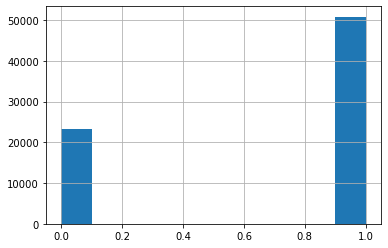

In [108]:
df.Lying.astype(int).hist()

<AxesSubplot:>

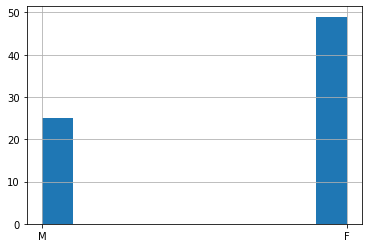

In [109]:
# dominated by females
df.groupby(['Subject', 'Gender']).count().reset_index().Gender.hist()

In [110]:
X = df.values[:, :-4]
y = df.values[:, -3].astype(int)

In [111]:
# normalize features
normalize = Normalizer()
X = normalize.fit_transform(X)

In [112]:
X_train, X_test, y_train, y_test, _, subject = train_test_split(X, y, df[['Subject', 'Gender']],
                                                                            test_size=0.3,
                                                                stratify=df.Subject)

In [142]:
m = LogisticRegression(class_weight='balanced', penalty='elasticnet', solver='saga', l1_ratio=0.99, max_iter=1000)
m.fit(X_train, y_train)
y_pred = m.predict(X_test)
print("accuracy Random Forest= ", accuracy_score(y_test, y_pred))
print("recall Random Forest= ", recall_score(y_test, y_pred))
print("precision Random Forest= ", precision_score(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
print("FPR Random Forest= ", fp / (fp + tn))
print("FNR Random Forest= ", fn / (fn + tp))

accuracy Random Forest=  0.8394268774703557
recall Random Forest=  0.8170135038162959
precision Random Forest=  0.9420791334436588
FPR Random Forest=  0.1110310021629416
FNR Random Forest=  0.18298649618370408


In [143]:
results = []
for i, row in subject.drop_duplicates().iterrows():
    smask = (subject.Subject == row.Subject).astype(bool)
    y_pred = m.predict(X_test[smask, :])
    #print(y_pred.shape, y_test[smask].shape)
    tn, fp, fn, tp = confusion_matrix(y_test[smask], y_pred, labels=[0,1]).ravel()
    #accuracy_score(y_test[smask], y_pred)
    fnr05 = fn / (fn + tp)
    fpr05 = fp / (fp + tn)
    scores = m.predict_proba(X_test[smask, :])
    fpr, tpr, th = roc_curve(y_test[smask], scores[:, 1], drop_intermediate=False)
    results.append((row.Subject, row.Gender, fnr05, fpr05, fpr, tpr, th))

In [144]:
results = pd.DataFrame(results, columns=['Subject', 'Gender', 'FNR05', 'FPR05', 'FPR', 'TPR', 'TH'])
results.head()

,Subject,Gender,FNR05,FPR05,FPR,TPR,TH
0,d2p24,F,0.030675,0.500000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.006134969325153374, 0.0122699386503067...","[1.851216711722166, 0.8512167117221662, 0.8495..."
1,d2p14,F,0.275321,0.142857,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0014265335235378032, 0.002853067047075...","[1.959585039852429, 0.9595850398524289, 0.9583..."
2,d1p53,F,0.108879,0.007092,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0010570824524312897, 0.002114164904862...","[1.7497760856804367, 0.7497760856804367, 0.749..."
3,d2p23,F,0.000000,0.224138,"[0.0, 0.0, 0.0, 0.017241379310344827, 0.034482...","[0.0, 0.3333333333333333, 0.6666666666666666, ...","[1.823798637453376, 0.823798637453376, 0.81047..."
4,d2p02,F,0.078563,0.857143,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.001122334455667789, 0.0022446689113355...","[1.9915010407979465, 0.9915010407979465, 0.991..."


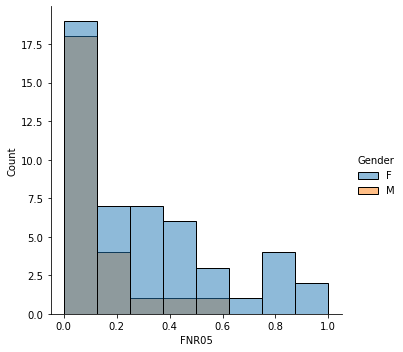

In [145]:
sns.displot(x='FNR05', hue='Gender', data=results)

In [146]:
results.groupby('Gender').FNR05.mean()

Gender
F    0.285493
M    0.115846
Name: FNR05, dtype: float64